In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
    X_hv = hv.fit_transform(toxic_data.comment_text)
    print("Shape of HashingVectorizer X:")
    print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    transformer = TfidfTransformer()
    X_tfidf = transformer.fit_transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    sc = StandardScaler(with_mean=False)
    X = sc.fit_transform(X_matrix)
    print(X.shape)
    if (not test):
        y = toxic_data['any_toxic']
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

In [4]:
# CHANGE FILE PATH and my_random_seed number: 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/Users/smolloy/Dev/parsons/ml-2020_data/toxiccomments_train.csv', my_random_seed=666)

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

In [5]:
# ordinary least square model

from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 12919, 'Neg': 114737, 'TP': 6519, 'TN': 57815, 'FP': 56922, 'FN': 6400, 'Accuracy': 0.5039637776524409, 'Precision': 0.10275689223057644, 'Recall': 0.5046056196300023, 'desc': 'ols_train'}


In [6]:
# SVM, linear model

from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12919, 'Neg': 114737, 'TP': 12851, 'TN': 114645, 'FP': 92, 'FN': 68, 'Accuracy': 0.9987466315723507, 'Precision': 0.9928919106853126, 'Recall': 0.9947364347085688, 'desc': 'svm_train'}


In [7]:
# logistical regression model

from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 12919, 'Neg': 114737, 'TP': 12859, 'TN': 114695, 'FP': 42, 'FN': 60, 'Accuracy': 0.9992009776273736, 'Precision': 0.9967444384156267, 'Recall': 0.9953556776840313, 'desc': 'lgs_train'}


In [8]:
# naive bayes

from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 12919, 'Neg': 114737, 'TP': 12672, 'TN': 103338, 'FP': 11399, 'FN': 247, 'Accuracy': 0.908770445572476, 'Precision': 0.5264426072867766, 'Recall': 0.9808808731325954, 'desc': 'nbs_train'}


In [9]:
# perceptron model

from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 12919, 'Neg': 114737, 'TP': 12825, 'TN': 114666, 'FP': 71, 'FN': 94, 'Accuracy': 0.9987074638089867, 'Precision': 0.9944944168734491, 'Recall': 0.9927238950383157, 'desc': 'prc_train'}


In [11]:
# ridge regression classifier model

from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12919, 'Neg': 114737, 'TP': 11671, 'TN': 114560, 'FP': 177, 'FN': 1248, 'Accuracy': 0.9888371874412484, 'Precision': 0.9850607697501688, 'Recall': 0.9033980958278505, 'desc': 'rdg_train'}


In [13]:
# random forest classifier model

from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 12919, 'Neg': 114737, 'TP': 0, 'TN': 114737, 'FP': 0, 'FN': 12919, 'Accuracy': 0.8987983330199912, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


/Users/smolloy/Dev/parsons/ml-2020/jupyter/_firstProject/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


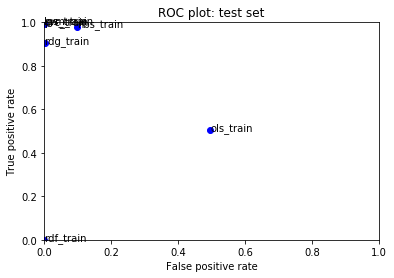

In [14]:
# plot to compare models

fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [15]:
# reviews based on classification

ols_predictions = ols.predict(X_train)

In [16]:
# false positives ** DON'T L@@K TOO MUCH**

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')

Examples of false positives:
70
In my opinion Dougweller is using his privileges poorly, for personal attack, or to play games and make a point.  It is my opinio that he should be blocked for abusing these priveleges
* * * * * * * * * 
82
One cannot start from the blood libel, because the blood libel came about much before Israel was created, and 9/11 should be mention in the article of course.Almost everybody has agreed the article should be renamed to a more suitable name, so I did.
* * * * * * * * * 
114
Can I please be unblocked. I have changed my username from a blocked one to 'The Three Jays'. I used the original one as it was a nickname growing up and I am ignorant of Wikipedia's rules. Mea Culpa King of Hearts!!!!
* * * * * * * * * 
207
See Talk:Chester_F.C._(2010). Thanks,
* * * * * * * * * 
214
, how can such a nasty user who swears all over the place not get one warning?? this is racism.
* * * * * * * * * 
232
I've mentioned this article at the BLPN notice board. It burden f

2463
Well, there are these images:

Let's say you wanted to include those. Where in the article would they go? It's already got plenty of pictures; which ones would you replace? Also, you would have to write alt text for the image describing it to someone that is blind. See WP:ALT. 68.187.39.100
* * * * * * * * * 
2555
I'm not sure what you wanted to say with that, did anyone remove the name Piestany from the article?
* * * * * * * * * 
2559
"

 Grier 

Hey,

I appreciate the work you're doing, but since neither of the articles you added discuss Grier in enough detail to satisfy WP:BIO, you'd have to make the case that ""first XYZ vice-chancellor of the New York diocese"" and ""unspecified bishops' advisory council member"" were notable in and of themselves. See List of African-American firsts as a comparison: the people on it are notable for being the first to do whatever it is they're the first to do, but they also apparently fulfill the criteria for WP:BIO because of things they hav

5070
Thanks 

Just wanted to thank you for your kind comments about my article USCGC Icarus (WPC-110). When my first few (previous) ships articles were reviewed, I got a lot of feedback about formatting, standards, etc - helpful and necessary, but not as satisfying as your 'well done'. Maybe I am getting the hang of things )
* * * * * * * * * 
5122
England:

R v Southwark Crown Court, x parte. Smith [2001] 2 Cr.App.R. (S.) 35
G plea before a magistrates' court possessing a firearm and ammunition without a certificate. 3 months imprisonment. D pleaded G on the basis that by failing to renew the certificates he was in breach of the law. The Divisional Court granted the application and substituted a sentence of 12 months conditional discharge.
* * * * * * * * * 
5123
96S.INVEST first appeared 2009-02-27, 1530z @ 10.0ºS 101.0ºE.
* * * * * * * * * 
5239
Thanks for your message. I responded on my Talk.
* * * * * * * * * 
5299
Like I said, whether or not they are far right can be discussed wi

8026
And 

Paganism

Southgate, who has a degree in theology and religious studies from Canterbury University, rejected Catholicism and moved towards neo-pagan and heathen groups that are ‘very loyal to the Gods of the Northern Tradition’, including the Odinic Rite, the Tribe of the Wulfings and the A ´ satru´ Alliance, a pagan movement concerned with practising rituals and magic and led by Valguard (Mike) Murray, a former member of the American Nazi Party.91 Further evidence of this transition from Catholicism to paganism emerged in an interview with Wotan, the organ of the Charlemagne Hammer Skins.92 Southgate believed that Wotan’s celebration of the heroes of the Norse pantheon represented ‘the most genuine expression of European spirituality, culture and identity’.93 Another key expression of this ‘identity’ is exhibited by Southgate’s interest in the militaristic cult of Mithras and the ‘pagan spirituality’ of the apostate Roman emperor Julian II.94

This rejection of Christianity

10601
"

 I apologize, but my point remains 

Hi. I apologize for calling you rude. But i think my point remains, if a word or a specific form of a word is rarely used it becomes ""obscure"" or ""archaic"". Believe it or not, language is defined by the majority of speakers who live in the present day. ""Formulae"" is a particular variant of ""formulas"" that has fallen out of favor, or common usage. Now since Wikipedia is a ""current"" encyclopedia, I don't understand why you feel the necessity to use language from the 1800s. How do I put this delicately... nobody uses this word anymore. Why dont you start an 1800s encyclopedia, and you can use all the various archaic English words. 
  I  would like to appeal this decision if that is possible. Thankyou"
* * * * * * * * * 
10626
rust can taste nice but only if you add some herbs and cheese one of my favourite recipes is the one by jimmy
* * * * * * * * * 
10631
"

I feel absolutely no shame for going ""SHEEEEEEEEGOOOOOOO!"" that's not a

* * * * * * * * * 
13064
"

 Removed text from article 
You're right the history section needs serious work.  I have removed it from the article because, I believe, it is a lot of conjecture.  It certainly doesn't jive with what I've read on the subject, and goes contrary to information found in referenced articles, for example country dance originating in frontier towns.  I would suggest that the country dance section of the folk dance article is read carefully.  

I would also suggest that careful citing of references in this history section will make it a lot better.  What happened to the role of the ""dance master"", and of ""recorded music""?  These are both important aspects of the caller's history.

It's a little too hit-and-miss for my taste.   

History
The role of the dance caller or cuer came out of necessity, given the origins of folk dance in America, but also in various cultures throughout the world.

In America, you can find many examples throughout history of frontier t

15666
"
""Wikipedia:Categories for deletion/botanists by nationality lists a 4-4 vote, which is hardly a consensus to make the changes you did. Some of the categories you emptied have been around for six months at least, such as British botanists, so it wasn't just an anon (who was most likely  18:29, 3 Apr 2005 (UTC)""
Hi Stan - several points; first, neither was there any consensus for Pcpcpc's (if they were his) changes in the first place; I was restoring the original status quo, not making a change. And no request for comment had been made at either WP:TOL talk or from regular botanical contributors, as should have been done, before making that change. Second, botanists are fundamentally different from (almost) all other kinds of people when it comes to nationality; e.g. uniquely only botanists and ornithologists working in Britain and Germany among all people maintained friendly communication and exchange of scientific information throughout the second world war. Third, yes, botan

18153
Oh yes, you must ban me.  Very much you must.  If you don't, you might have a useful encyclopaedia that works towards providing facts.  We wouldn't want that now, would we?
* * * * * * * * * 
18234
If Komsomolsky is masculine, Komsomolskoye neuter and Komsomolskaya feminine, why does every link points to Komsomolsky and not Komsomolskoye that its neuter?? Just a tought.
* * * * * * * * * 
18251
See WP:BAND for what a band need to have achieved before they can have a Wikipedia article.
* * * * * * * * * 
18314
You are wrong. Neither of the sources in vague. They are both very precise indeed, and since these facts were made public, neither Nick Clegg nor his party has succeeded in bringing any defence or counter-evidence. They are admitting the accusations are true.
* * * * * * * * * 
18330
wow, wonderful work! keep digging up academic sources and continue to re-write!
* * * * * * * * * 
18341
"
...this includes the online variations. ((⊕)) "
* * * * * * * * * 
18362
I don't see yo

20603
That has nothing to do with what I'm saying. I can find articles that say teh same thing about Turkey's influence in the middle east. The provided articles state that in each reason Turkey has a growing influence. so why only write that the influence is present in the Middle East if it has growing influence in both Areas. You are selectively telling the truth. Including the Middle East to state that Turkey is Middle eastern and excluding the Balkans to say Turkey cannot have an influence in Europe when both articles state the same thing.  03:33, 15 August 2012 (EST)
* * * * * * * * * 
20609
"

Speedy deletion of Steven Jones (dentist)
 A tag has been placed on Steven Jones (dentist), requesting that it be speedily deleted from Wikipedia per CSD a7. 

Under the criteria for speedy deletion, articles that do not meet basic Wikipedia criteria may be deleted at any time. Please see the guidelines for what is generally accepted as an appropriate article, and if you can indicate why th

22940
"
I wish that was possible, but it's not. Your protection options are full protection, where only administrators can edit it, or semi protection, where any autoconfirmed user can edit it. See WP:PROT, it has all the possible protection types and more specific information on them.  (T•C••) "
* * * * * * * * * 
22970
February '07
Please do not add nonsense to Wikipedia. It is considered vandalism. If you would like to experiment, use the sandbox. Thank you.
* * * * * * * * * 
23044
16, 18 August 2008 (UTC)

Captions tell the history of an aircraft - if you are going to have a picture of an aircraft then you need to tell its story and background - this is only common sense if not for readability then for accuracy in reference. If you were to google F-16 this article is one of the first to be found so this make accuracy and completeness essential in these article (and it does not add too much more in size).  If wikipedia was a dictionary then a simple caption would be ok but tbut wik

25494
That sig I showed you 

It uses up an entire kilobite!!!!!!!!!!!!!!
* * * * * * * * * 
25628
He's something that starts with P and rhymes with Rick.
* * * * * * * * * 
25643
Think of it like me painting over graffiti scrawled on the side of my building.
* * * * * * * * * 
25705
Unitarian Universalism work group 
You may be interested to know that there is now a work group for all things UU. It's at Wikipedia:WikiProject Religion/Unitarian Universalism work group.
* * * * * * * * * 
25727
Napoleon Dynamite
Did this song feature in Napolean Dynamite at the beginning of the film? Or was that the older version?  Who wrote this first version SineBot is talking about?
* * * * * * * * * 
25734
Please do, all you will find is that novaseminary has a very bad history of edit warring, pov editing, and being uncivil.
* * * * * * * * * 
25746
New Delhi 

This is in reference to your this edit. Please refrain from adding inaccurate material to Wikipedia articles. Do sufficient research before

27975
"

 Legal threats and right wing behaviour  

Please don't make legal threats towards others users in this platform. This type of behaviour is not acceptable under any circumstances. Also making nationalist or right wing comments isn't suitable on here, try to keep yourself neutral while editing on articles or talk pages.  - írísh αnd prσud "
* * * * * * * * * 
28071
Because I most of the time they are updated incorrectly and I can take care of the page myself. Thanks
* * * * * * * * * 
28142
Here you want a credible source citing this fraud http://comm.colorado.edu/~jacksonj/research/coon.pdf

There and I am reporting you for this.
* * * * * * * * * 
28148
"

 Re:Advice needed 

I think posting on WP:ANI is a good way to bring attention to what's happening.  At this point I don't know if there's really anything else to do, unless the same user shows up again.  And even if s/he does, there are a lot of other users (including admins) who are aware of the situation and will spring 

30412
Use , and fill out the fields.. Thanks for adding the source... would also be useful to have the date and catalogue numbers if possible )
* * * * * * * * * 
30427
, 20 May 2007 (UTC)

It is a neutral point of view. The article is just explaining the reality of Spain. Otherwise, ignoring this reality, would be lying. What would you add / remove, then ?  19:17
* * * * * * * * * 
30495
Good points. And even with these it can be covered well in subsection form at Indophobia, hence the merger proposal.
* * * * * * * * * 
30538
Yeah we're eagerly awaiting the bot.
* * * * * * * * * 
30560
"

""Jihadist"" qualification
I hope this is acceptable.  Let me know if not. ~   "
* * * * * * * * * 
30621
Known for money laundering 

D'Souza is so well known for money laundering that the talk page is full of discussion, yet a user keeps removing that from the page. A little bit ironic there... ulterior motive?
* * * * * * * * * 
30666
Note to readers of the talk page: see Neo-Darwinism.
* * * * 

32665
"

Agree with the first part, the injunction is notable, the extra-marital affair is not. Until the coverage of this goes beyond a couple of rather obscure Irish media sources, it fails WP:BLPNAME and WP:UNDUE. (talk to me) "
* * * * * * * * * 
32718
However, besides the already known hypothesis that gender preference might be less resolved in pedophiliacs than non-pedophiliacs, I don't see that the results quoted in the article suggest any causal relationship between homosexuality and pedophilia, or vice-versa for that matter.
* * * * * * * * * 
32811
"
The thing is, it isn't an ""issue"". It's DRM. The section should be DRM, then state the points and counterpoints. talk "
* * * * * * * * * 
32884
Hmm, that's just some quicksilver ISP subscriber's web page. Not a reliable source.
* * * * * * * * * 
32992
iono were the play was performed on broadway any help? preicate it
* * * * * * * * * 
33061
"

JPGordon - Answered on user page Talk "
* * * * * * * * * 
33069
br>

If you're go

34684
The flight is now bookable...now to commence on June 8, 2012 instead of May 22. The flight will be operated by Continental and not United per schedules.
* * * * * * * * * 
34705
it seemed simpler to list it at afd and give my opinion there. See Wikipedia:Articles for deletion/Jebi Mather Hisham. (I was also thinking about G11, but though the intent is promotional, the wording isn't) '''''' ( talk )
* * * * * * * * * 
34827
"

Thank you very much!
  The Random Acts of Kindness Barnstar Thank you for your help and work on the WP:LGBT Random Picture template. It is very much appreciated!     ECHO "
* * * * * * * * * 
34854
I dont mean to be insulting, but. . . 

Its not a hoax, its the real people saying global warming is the hoax. Read the news once in a while.
* * * * * * * * * 
34896
IBO
I'm not trying to vandalize, but the IBO is a meaningless, irrelevant sanctioning body. It's not legitimate, so shouldn't be recognized. Don't you agree?
* * * * * * * * * 
35006
Well, I assumed 

36793
"
I don't see anything interesting about it at all, frankly, but it can certainly be mentioned if you feel it's important. How about ""Derwick's first project was the award of 12 power station contracts in Venezuela during a 2009-2010 energy crisis in that country.""? That gives the information but isn't open to misinterpretation like the original wording was. Are you happy with that?Let's play Freckles "
* * * * * * * * * 
36812
"Momento, Mr. Obama did not found the United States of America, he does not preach the ""message"" of the United States of America, he did not develop the theology of the United States of America, and he has never declared himself or his wife to be an incarnation of a god. Prem Rawat is all of these things, so you see, Prem Rawat is the DLM.  talk,  

"
* * * * * * * * * 
36821
History? ==

Can someone provide some information regarding the contracting of the AC service area? AC Transit used to serve most of the cities of the 680 corridor, but the cities

38777
of the administrators
* * * * * * * * * 
38795
"

 Not made in USA or UK 

That says it all! Not everybody lives or reads in one of the imperial powers. I write for those struggling with English in ""lesser"" countries. I am sorry I can no longer offer to stop writing articles and stop donating - I did that in response to a (prob male) bully who deleted an article of mine. Now a (prob female) bully comes out of the woodwork. I guess it gives a sense of power to otherwise impotent people. Time to change IP address ..."
* * * * * * * * * 
38872
"

No i hadn't read infobox television until today. Is it new? From my time on here i don't remember the ""last aired"" parameter being interpreted this way. Its usually strictly used when the series has ended. And no i don't know who made that edit.   

"
* * * * * * * * * 
38917
please report to the talk page for discussion
* * * * * * * * * 
38954
"
{| style=""background-color:#F5FFFA; padding:0;"" cellpadding=""0""
|style=""border:1px so

41114
There is no disagreement on whether Goguryeo is part of of Korean history.  THe Korean history template is not controversial.  The Chinese history template is highly controversial and is THE POINT of disagreement here.  Chinese history template should be left out until the dispute can be resolved.  Especially since the claim is being made in part of the recent Chinese government supported and funded NOrtheast Project that's rejected by even Chinese academics.
* * * * * * * * * 
41153
Turkey Wikiproject TERRORIST 
The terrorist can't support Turkey wikiproject, can't neutral.
* * * * * * * * * 
41165
Riyadh Military Hospital
Thanks for your guidelines on my above mentioned article, but you put a notice on that article saying for speedy deletion. well, I am new on wikipedia and with the help of friends like you, i am getting better and better. Review my article again and guide me if I may improve its standard? It would be very thankful, and yeah, pardon me if i am putting my talk c

43197
Falangist partisan  needs to stop abusing the editing process to do damage control on the egregious misbehavior of his hero Juan Carlos.  Accurate, sourced, relevant information on the King's alcoholic rantings should not be suppressed just because you find them inconvenient.
* * * * * * * * * 
43205
Iridon 3D review 

The review was only a short one so I typed out all of it.  You can find it on this page
* * * * * * * * * 
43211
Road speed?
Side says road speed: 58. Is that Km/H? Artcle says 36 MPH which converts to 58 Km/h so just wondering, not sure
* * * * * * * * * 
43238
"

 Sitush: You should not repeat this behavior. This constitutes vandalism. I have no option other than citing you for this. Please check the warning on your talk page 80.84.55.217  

Your behavior also looks like ""taking ownership of this talk page"". I will post another warning for this. 80.84.55.217  

"
* * * * * * * * * 
43243
why do you hate me, i'm just trying to add some truth to the greater metav

45646
Finally, Richie Ramone has family in Arizona. Surely you will agree that, considering the zeal expressed here for his private life, rather than his work and legacy, we don't like giving out anything, but maybe that clears it up. But there is no drama around Tommy Ramone. He and CJ Ramone live just as quietly as Richie Ramone. To us, these are excessive occurances of prying into his private life.
* * * * * * * * * 
45912
"

 POV classification of Major works 

I am rather curious about the classification and comparing it with great works like Kumarasambhava, Meghaduta, Gitagovinda etc. IMO, the WP:OR comparisons should be removed. Also, third-party references are needed to support the classification, especially classifying some works as the mahakavyas.   Talk  "
* * * * * * * * * 
45914
At least answer this question for me little guy: Why do you feel the need to bolster your low self-esteem being a cyber bully? Were you shunned at school dances, maybe stuffed into lockers? You're 

48635
It pains me to quote Mr Wales, but this is actually quite clear:

 From Jimbo Wales, paraphrased from this post from September 2003 on the mailing list:
 If a viewpoint is in the majority, then it should be easy to substantiate it with reference to commonly accepted reference texts;
 If a viewpoint is held by a significant minority, then it should be easy to name prominent adherents;
 If a viewpoint is held by an extremely small (or vastly limited) minority, it does not belong in Wikipedia regardless of whether it is true or not and regardless of whether you can prove it or not, except perhaps in some ancillary article.

Keep in mind that in determining proper weight we consider a viewpoint's prevalence in reliable sources, not its prevalence among Wikipedia editors.

If you are able to prove something that few or none currently believe, Wikipedia is not the place to premiere such a proof.  Once a proof has been presented and discussed elsewhere, however, it may be referenced. Se

51746
I've written a stub for this type of poor relief 
see indoor relief
* * * * * * * * * 
51750
You do not have the authority so to do, not even from your own Lodge lket alone your own Grand Lodge.
* * * * * * * * * 
51758
"

I just read the section Urumi (film)#The English version, and I see that it is to be titled Vasco da Gama. Is this the film Sivan was commenting on in the ""Production"" section? If so, I think that ought to be made clear.   "
* * * * * * * * * 
51895
"

 OK, thanks.  I appreciate the ""heads up"".  It was a page that I created several years ago ... and then, more or less, I forgot about it.  Thanks a lot!   (  )"
* * * * * * * * * 
51898
"

SVG on Commons
The only problem? The software I use doesn't utilize or recognize SVG. And I have no idea how to translate or any software (freeware) that is available. So if someone would point me in the right direction and give me a few pointers about how to do SVG... well, maybe then. The idea of ""cleanup"", however, is 

54320
":::: In 1937, the Bridgeport Sunday Herald stood behind its article as authentic ""proof"" that Whitehead flew, and opened its files up to the Library of Congress. No hoax was found. In fact, Dr. John B. Crane issued a complete reversal of his earlier position, supporting the flights of Gustave Whitehead, once he heard the testimonies of witnesses and saw the extent of the proof. Your personal opinions are impacting your wild editing herein, Mr. Carroll, and it is not appreciated. It is that sort of behavior that gives Wikipedia the very bad name it deserves, if it allows this to go on. This Talk page is a great example, which I have a record of, that will be used to discredit Wikipedia with regards to being a source of reliable information. This is especially due to Mr. Carroll's desperate and inappropriate editing. Stick to your own website for your hoax conspiracy theories. The only hoax is the one you are trying to promote, it would appear.   

"
* * * * * * * * * 
54341
"Ct

57337
So clearly livelikemusic has two (or more) of them or you wouldn't have brought it up. Lovely.
* * * * * * * * * 
57469
"

What do the three edits Feb. 24 have to do with the sock puppetry investigation of COI from 2006 and early 2007?  This all seems like a big stretch to formulate a grand conspiracy theory where there isn't any. Editors were aware of the COI back when it happened (years ago) and dealt with it.  The article is edited and watched closely now. 

Are the only recent edits those three attempted additions to the Barack Obama article? Hardly a high crime it seems to me.  What you're really upset about is that someone did an unfavorable (but accurate) story about how all attempts to include any mention of controversies or criticisms in the Obama article were reverted. News flash, many of us have had the exact same experience this editor had. If we block users for editing under ""false pretenses"" so be it, but lots of editors post on other sites about their experiences

60211
Thank you very much for your encouraging words. However, I made my dicsion after doing a thorough checking of Arbustoos's footprints on the Wiki. I notice that he has been systematically deleting information related to conservative Christians and conservative Christian organizations. He mutiliates where he cannot delete. And he adds information in such a clever manner that even what is right leads to humiliation. (An apology can be more humiliating than an insult). What is more, I notice that none, repeat NONE, has been able to stop his adventures. He is freely doing what he wants to and none of you has been able to stop him from his anarchy. Else, show me one example where any of you has stopped him in his tracks. Why is it that he has always got to be right??? His POVs are NPOVs while researched stuff by us is POV or simply garbage because there is no arbitrator between him and me. Just show me one example of arbitration in my case. I also notice that others who contributed to 

63155
Name

If her name is Lucrezia, why does her gravestone say LVCRETIE which would give a nominative Lucretia?
* * * * * * * * * 
63197
"

RE:
Uhhh...maybe you didn't notice but the English wiki isn't updated on any tools that use the ToolServer anymore (for over a week now) - including interiot's and kates. That is what the flashing text ""en.wikipedia.org data is no longer updated"" means. I actually have 5100 something edits at this point.  "
* * * * * * * * * 
63198
What was wrong with my edits to Roses.
* * * * * * * * * 
63224
Um, you're confusing your terms with the technical thermodynamic meanings of the terms intensive and extenstive. Intrinsic and extrinsic are somewhat loosely defined terms of ordinary language. Don't use them when you really mean intensive and extensive. My revenge for your spelling pettiness ).
* * * * * * * * * 
63315
"
 It looks awfy dark to me, but hey. It looks fone on Vector, sooo...  f o x  "
* * * * * * * * * 
63327
It looks like the corruption o

65732
Resolved - tagged as
* * * * * * * * * 
65744
So now you are assuming insult by the term Irish Republican?
* * * * * * * * * 
65769
2010 (UTC)

Murder her. 16:42, 21 October
* * * * * * * * * 
65789
(addition: the present map actually still erroneously shows Sindh as part of the sassanid empire during 620 CE. While there may be a case during the early Sassanid period, there doesn't appear to be one post-huns as independent hindu/buddhist dynasties ruled there. I should also note that it is important to distinguish between territory and tribute state.)
* * * * * * * * * 
65895
How would it be if this page were altered so that there are only links and no transclusions. Somewhere on the page there could be a link to (for example) List of federal by-elections in Canada (details) that has the links and transclusions?
* * * * * * * * * 
65909
You and everyone deleting the 8 Prime Spirals are all LIARS the original article was CITED it cited peer level speed tests of all the top prime a

68291
"

What???!!! What? Has reason finally prevailed???? I proceeded to edit the Rand piece as promised just supra , lo and behold, LaVey had been subject to a waylay. He's no longer in the ""influenced"" box. What happened? Who did the dirty job? Why? Again, I'm obssessed with reasoned discourse. AOluwatoyin"
* * * * * * * * * 
68333
so how do you tackle those that gang up against you? You just let them be? How conveniant!
* * * * * * * * * 
68407
They won a Grammy for it, what more proof do you want?!
* * * * * * * * * 
68454
omg, you came here and blocked me with no reason? it won't be stop here.
* * * * * * * * * 
68459
"

 Userpage Deleted 

I have deleted your userpage due to it being used as webspace/attack page.  Please refrain from creating inappropriate userpages and vandalism or your account will be blocked. (talk) "
* * * * * * * * * 
68486
"== Turkey etc. ==

Hallo !

Turkey and the other states are not European states. Geographically Turkey, Kazakstan, Aserbeidshan, Arm

71201
Go ahead and merge what you think is necessary. I'll review your edits and create a redirect. timecop
* * * * * * * * * 
71211
Francis Cyrus Hobart Hutchinson 

The source for my article was Burkes Presidential Families of the United States of America. Burkes Peerage Limited, 1975 edition. This i believe very out standing source. I had it here and had to find it again.    Randall O
* * * * * * * * * 
71242
"
Thank you! -   Talk "
* * * * * * * * * 
71296
What has accent have to do with it? Does it matter what accent he spoke with?
* * * * * * * * * 
71401
"

 The Last Sontaran 

Would you mind if I GA-review The Last Sontaran? I've previously reviewed Jenny (Doctor Who), which eventually passed, among numerous other GA articles. Wikipedia:Reviewing good articles suggests that those with ""personal feelings about the merit of the article subject"" should not review the aricle, but I do not consider myself one of these people.  My only previous edit to this article is assessing it 

74049
Yes, I am still curious to resolve in my own mind how the Old Kingdom pharaohs could have possibly existed so late and coexisted with the Heracleopolitans as your source suggests.  I am also curious if the artifact for Unas was the one from Byblos.
* * * * * * * * * 
74068
"

 Please do not vandalize pages, as you did with this edit to Lukas. If you continue to do so, you will be blocked from editing.    "
* * * * * * * * * 
74155
Don't you have a real job? 

Maybe you should read How to talk to a liberal, but only if you must, by Anne Coulter.  Also, maybe you would realize the brilliancy of conservatism if you actually worked.  Liberals are such crazy people!  Almost like children, they can not see the forest for the trees.  So very impractical and non realistic.
* * * * * * * * * 
74335
Im not trying to be funny but, which part of the Electromotive force and voltage difference para are you having difficulty with?
* * * * * * * * * 
74437
The new name is unwieldy and not in lin

77023
-=unblock | reason=your reason here i shouldnty be bloxcckedb sbbeacsuse fewotgbe shiu-#dan  leonard did this so please i think we should assinate him and then we are the best and you eat poo
* * * * * * * * * 
77092
"

This is an excellent article and a valid subject and deleting it is an absurd idea. 
There are many sources that support the validity of an article on Military Kids as an identifiable subculture 

1) See the award-winning book by Mary Edwards Wertsch: ""Military Brats: Legacies of Childhood Inside the Fortress"" 

2) See the award-winning documentary: ""Brats: Our Journey Home"" by Dona Musil (it won 19 awards). 

3) See numerous novels released in the last several years on the Military Brat experience. 

4) See the Oscar Nominated movie ""The Great Santini"" based on the book by the same name by Pat Conroy.

No one of these works alone could represent the whole military brat experience but they altogether point to the existence of a huge identifiable sub-culture 

79960
Until someone gets the info about all these other investors and posts it, doesn't it make sense to list the investors we do know of? Isn't Bin Laden worth mentioning? Let's not let the limited information on Carlyle's investors stop us from providing the info we do have because we're trying to maintain NPOV, particularly when the information is clearly compelling, relevant to understanding at least one view of Carlyle group, and possibly meaningful. The weasel words and the original research warnings are not necessary, at least for the Controversy section. And, I changed some of the weasel words in the Controversy section, although the meaning remains largely the same  how else are we to provide the information, which is pertinent, about how an issue or thing is perceived by people?!
* * * * * * * * * 
79983
"

I notice that we have a Category:European goddesses. It would appear that most European goddesses are individual personas, just like everywhere else. I think what some wri

82966
NJPA 

please discuss content not slandering other wditors whiel clainming you have been slandereed. CONTENT is for discussion not attackign other editors on presumption!(  ).
* * * * * * * * * 
83012
I see that my edits have apparently been reverted wholesale.
* * * * * * * * * 
83137
Who is the quote from?
* * * * * * * * * 
83142
"

 FYI 

  This is just to bring to your attention that this last edit to Fibromyalgia puts you at 3rr.  You have reverted multiple editors during this so I would like to suggest that instead of edit warring about it, please take your concerns to the talk page to discuss.  I am sure the editors will be willing to talk to you about this.  Thanks for listening, Talk "
* * * * * * * * * 
83204
"** Inferences from map colours is original research. Ditto below. The country list clearly lists Taiwan as a sub-national entity under the country entry for ""China"". 
"
* * * * * * * * * 
83210
"

 Sonja de Lennart 

Cretae a new article for ""Sonja de Lennart"

85584
"

 Template:Mormon_jew 

Looking at a new article called Groups Exiled from Judaism, and not quite sure what to make of it, I was shocked to see that the well-used Template:Jew has now been ""taken-over"" by a pro-Mormon user and a new similar-looking Template:Mormon_jew is now being utilised. This Mormon template plagiarises and makes confusing use of the original Template:Jew. The Mormon template must be radically changed ASAP. Your attention is needed. Perhaps we should follow official channels too. Thank you.  "
* * * * * * * * * 
85587
Hello, please refrain from pushing your views on Wikipedia. I understand that you identify strongly with and support the values of the former illegal state: The Confederate States of America which was founded on the principals of racism and slavery. Since these are extremist and reactionary positions in our modern society, I recommend you think carefully about whether your contributions truly advance the goals of Wikipedia. Thank you.

Best,


88208
Forgive me also. I must be in attack mode all of the time on the Internet. It just sounded like you were poo-pooing any discussion of the topic.

I'm not a newcomer, I have another account but I ditched it because it's tied to some articles I don't want to be associated to. I believe that, if there was enough interest, I could put together quite a case for my theory on who killed Trudy Monk. I've put a brief description on my talk page. Trudy's murder is a MAJOR part of the series, but since discussing it on the main article page would ruin the suprise which will come at the end of the series, I put it on my userpage. Lots of members use their userpages for things like that.
* * * * * * * * * 
88364
"

 Accusations directed at  

I have posted this here in an attempt to grab everyone's attention. While its place here may be disputed, I ask that it remain, for the purpose of getting read by everyone who needs or likes to. 

To whom it may concern: I am . This is the only username 

90968
"

At the time I took the photo of the cylinder it was to relate to the line ""Cylinders containing such mixtures must be clearly marked with that depth"", so that we had at least one image on the page. It's probably not so important now, so it could go, although it is the only diving-related image on there. However, I've noticed that GA's & FA's often have a top-right image - I was considering trying the pulmonary oxygen toxicity in a rat lung pic there but wasn't sure how it would look with the Toxicology and poison box going underneath it. Maybe they could both go top, in which case we could keep the cylinder? In the Quick suggestions section on the talk page,  suggested one image per section, what do you think?   "
* * * * * * * * * 
91007
REDIRECT Talk:Like It Is (public-affairs TV series)
* * * * * * * * * 
91088
I would file a RfC if I thought this was a content dispute. I don't think we are able to really discuss content at this point. Hence the ANI.
* * * * * * * * * 
91

93230
Please also keep in mind that your contributions need to make sense.  I have no doubt that your contributions are being made with the best of intentions; however, it is less work and stress for everyone (including yourself) if you make them the right way to begin with.  Thanks!
* * * * * * * * * 
93269
, DO NOT simply revert the edit
* * * * * * * * * 
93329
Hey Anma 

Sorry I haven't dropped by yet since you switched user names. Hope all is well ... been busy fighting off a new Disney vandal, and no it ain't him. I've been keeping in touch with PMDrive, and I look forward to his return in the future. Take care!
* * * * * * * * * 
93360
Closing CfDs 

Hi, Cyde.  Last night, your bot closed out a CfD by moving all the pages from Category:Scottish New Zealanders to Category:New Zealanders of Scottish descent.  Great.  But it didn't observe that the latter category contained a  template.  So when  ran a couple of hours later, it moved all the pages back to Category:Scottish New Zeal

95680
"Indeed, excellent work with the Antarctica stub sorting too. You should go back to creating stubs I think. Moaning about ""sub stubs"" is so 2008.... Wikipedia is going to be around for a long long time by the looks of it so why not start content which can be built upon...♦ Dr. Blofeld 

"
* * * * * * * * * 
95684
What is going to be the name of Kosovo are going to disaid Kosovars. But this is for the moment irelevan. We have here a historical article witch is presentet like a present article.
* * * * * * * * * 
95744
"

 Revisions to current article 

This article is too long according to Wiki regulations (one more reason to limit the amount of anarcho-capitalist info). As part of a solution to this, could ""Examples of 'successful' anarchies"" be moved to its own page?"
* * * * * * * * * 
95747
Hello Chongruk, welcome to Wikipedia.

You might find these links helpful: How to edit a page, How to write a great article, Naming conventions, Manual of Style. You should read our pol

97238
"
 Requested move 

Charles G. Stelle → Charles C. Stelle – The middle initial is incorrect: it is C (for Clarkson), not G. A correct web-accessible mention of this person relating to his time in the US Second Army in China can be found in the register of the Albert C. Wedemeyer papers located in Stanford University's Hoover Institution Archives. The URL is http://oac.cdlib.org/findaid/ark:/13030/tf3x0n99pv where on page 59 there is a listing of a document by Charles C. Stelle entitled ""Contemporary China"" in folder 44 of the Second United States Army section of the archive. 

Many other references to this person from a later period of his life may be found in the NY Times archives, for example in the article of June 21, 1963 on the signing of the ""hot-line"" communications link between the White House and the Kremlin: ""Charles C. Stelle of the United States and Semyon K. Tsarapkin of the Soviet Union signed the accord in their capacities as leaders of their countries delegat

98854
Ok, I do apologise for my slight outburst above. However I do not see how the image that I put up is not free when the person who took it and appears in it gave me direct permission to use it. Are the only kinds of images you can put on here really old ones, screencaps and pics your took yourself?
* * * * * * * * * 
98960
"
Okeedoke, Capt Tsk-Tsk, what now?   The wholesale deletions of the contributions of several editors (w/o talk page  engagement) were the violations of consensus.  My last restore omitted Olbermann portion and restored the sources.  What now?  You seriously ready to argue that the establishment of  a ""Beck U"" is a bland/non-responsive topic(e.g., Joe's School of Dance and Finger-wagging?)?  "
* * * * * * * * * 
98971
Well at least Richard did not tell me to stick in my ear this time.  So when Richard isn't making a bigger mess and protecting some editors like Esoglou while reprimanding other editors for like behavior (i.e. Leadwind) he's telling people to do 

100896
you or Terra are advocating
* * * * * * * * * 
100903
Community de-adminship 

What are your exact feelings about running straight with 70/80 - do you really think it has a chance?
* * * * * * * * * 
100941
Restored link to www.middlebass2.org 

An external link to this site has been deleted several times because the home page contains ads. But this is a legitimate site that offers a great deal of valuable information. I don't think it should be disqualified just because it has a few ads to help pay the bills (so does the New York Times).
I came across this controversy because the webmaster complained in the comments section of a NYT story about Wikipeida. I think he has a legitimate complaint. The best thing we can do is to use the information in that site to improve the article. Please consider doing that before deleting the external link. Thanks.
* * * * * * * * * 
100996
", 18 June 2007 (UTC)
As long as they are good-faith tags, I see no reason to stop. All articles has to c

103027
Image up for deletion
Can you check this out and advise. Regards.
* * * * * * * * * 
103065
In observing this drama, I would consider Goethean to be highly partisan in this subject.68.57.193.169
* * * * * * * * * 
103104
Can we still wait until Nintendo releases the boxart?
* * * * * * * * * 
103143
gueeeeesssssss whoooooooo ! D:D:D
* * * * * * * * * 
103170
"

 Stop male infant genital cutting. The National Organization of Restoring Men has info about  circumcision and restoring foreskin 

Male infant circumcision is why all this is happening. Learn about circumcision and get the word out on Occupy Wall Street. 

RE-imagine by TRILLION feat Andy Gibson (John Lennon Tribute)
http://www.youtube.com/watch?v=5C7Unc0riTk

WAKE UP!!!
http://www.youtube.com/watch?v=LAhA-Yd5Nl0
http://www.circumcision.org/index.html

more information including sign messages.
http://davidwilton.smugmug.com/Groups/San-Francisco-Pride-2010/13843046_DmCc48#1015380438_VcjCs
http://davidwilton.smugmug.com/Gr

105051
"

 Cluttering royalty articles 

in the article Line of succession to the Romanian throne, you added middle names, unsupported additional surnames, and whatnot, to the names in list of family members of king Michael. I empathize with your desire to embellish and decorate, but still in my view such details are clutter, in an article where they are just small parts of one list. Could you kindly refrain in the futire from cluttering articles, please. By the way, are you not aware that the invented additional surname ""de Laufenborg"" is commonly laughed at (probably as that son-in-law's fantasy ideas of his promotion to nobility), and king Michael has not used it as part of his granddaughter's name, as far as can be detected from sources of that article.   "
* * * * * * * * * 
105090
A tag has been placed on Phlux Web Operating System, requesting that it be speedily deleted from Wikipedia. This has been done under the criteria for speedy deletion, because the article seems to be b

106619
"OK, then please explain why a page about a newspaper called the Antelope Valley Press is more notable than a page about a newspaper called the AV News when BOTH publications cover the same area of Los Angeles County. Why are you allowing them to stay up? As for the pasted and deleted content, after my first attempt to create the page was deleted I thought there might be a format issue so I copied the entire AV Press page as a template and then REPLACED ALL OF THE TEXT ABOUT AV PRESS with the text about AV News and the website link thinking that would resolve the issue. As for my use of ""our"", that was my outrage and having a page deleted almost as it was posted and I should have worded it better. I do not work for the AV News but I was asked to see about getting the page up by others who think people looking at wiki should be aware there are more media outlets in the area than AV Press. I am not sure what other references you need other than the bloody website. Perhaps you co

108383
Is good, no? No. Of course not. Now I tell you again, if you have any concern, go the talk page where the thing is being discussed and stop taking up space here.   ).
* * * * * * * * * 
108502
"Well, I personally don't think ""he"" is the right term. I would understand if IT gets reassignment surgery, then ""he"" MIGHT be appropriate, but I don't think if I walk around calling myself the opposite sex that I was born as (assuming i did not have reassignment surgery yet), all pronouns in the entire world referring to me should be reversed. If there is this much debate, then don't use pronouns at all. Just say Chaz or Chasity.

"
* * * * * * * * * 
108534
What does any of this have to do with crime? deleat this at once, or move it to a section on boring white people.
* * * * * * * * * 
108552
Anderson is not a Church Spokesman
The article identifies Damian as a UC webmaster and church spokesman. He is neither. His web site is privately owned and sometimes runs afoul of church polic

110272
First Civilization on record? 

Is this statement authentic and approved by archaeologists?
why is the date different from the one mentioned on the site http://en.wikipedia.org/wiki/%27Ain_Ghazal ?
* * * * * * * * * 
110338
"

 Whoops! 

Whoopsie!  I didn't mean to revert your edits to the article Cahnite.  I did it as I was looking through the edits that were added to the article that I wrote when I accidentally clicked the rollback button ).  Hope you can forgive me.  Cheers, flame "
* * * * * * * * * 
110360
"Hi! I'd just like to know why you are removing information form the article Walter Koenig. Just reply under this, and sign your reply with four tildes (~~~~) Thanks! clawx "
* * * * * * * * * 
110406
July 2010 (UTC)

 Gotcha.   02:19, 31
* * * * * * * * * 
110487
"Gringo is half-way correct. ""Lesser Magic"" refers to psychology and social-engineering, whereas ""Greater Magic"" (-usually-) refers to rituals, which of course are merely viewed as theatre. One can assume th

112231
"
My experiences came up on the talk page but once I understood Wikipedia I didn't post anything on the article related to my personal experiences. That was like the 2nd day almost two months ago.

All of my references are verifiable.There's nothing in the article about my law suit or my being put in jail for engaging in pro se litigation.  I didn't put my experiences in the Judge Edward Nottingham article either although he was my judge.

I went out of my way to search for references expressing all the various sides of the issue. For instance, I wrote to the ABA and asked for their input, and in fact, asked them to work on the article. I also posted about issues involved with mediation and settlement with pro ses, citing references from a lawyers point of view.  Those references were deleted by someone, I can't remember who and don't know why. At this point, the only reference that I posted that is soft at all is a blog quoting a transcript quoting a former federal judge and I 

114350
"Restored Trivia, Removed Plot Spoiler ==

I removed the plot because it was a spoiler and unnecessary. I also added some trivia back to the article in a new section called ""Background, History, and Pop Culture"". I added what I could see fit naturally into a paragraph. After more than a year and a half of watching this article I have seen no effort to fix it up, or remove the total plot synopsis which is not a necessary thing to post on Wikipedia.  21:06, 02 December 2008

== "
* * * * * * * * * 
114354
That's more or less the existing guideline. — (talk • contribs)
* * * * * * * * * 
114361
"

 Github 

Hey man, looking at the Github I saw you posted on the talk page about the sexual harassment thing.
Is there any reason why that's not in the article, not that I care, it shouldn't be in my opinion, but it seems several major outlets covered it, why is it that these particular sources are ignored, wasn't Wikipedia about ""what RS say, not the truth""?   "
* * * * * * * * * 
11

116788
Why do you people put stuff like this on here? I have a floating IP, and so this message is NOT meant for me!!
* * * * * * * * * 
116790
The object of the match is to put your opponent through a table.
* * * * * * * * * 
116806
(sound of head banging on keyboard) ok, but it is not a common common name, many parrots have archaic and multiple names.  (talk · contribs)
* * * * * * * * * 
116843
Re: Please stop duplicating text 

Re: For the second time in a few days, at Talk:Border gateway protocol, you have duplicated dozens of lines of material.  I removed one section, but now you've duplicated Part 2.  This one looks inadvertant, but is nevertheless frustrating.  It is doubly so given the fact that you have overfilled the 50 kB article size threshhold by discussing much material that beats around the bush, is not in dispute and has not been clearly related to the capitalization question which is at issue.  This just makes it harder for others to read and comment, and what we nee

118982
" chauvin-0 This user chooses not to listen to ultra-nationalist rhetoric, of whatever nation. 
"
* * * * * * * * * 
119048
"

Idea for Further Reading
I am proposing the addition of a further reading section to this article. I have recently come across a book that I think would add more depth and breadth to the topic. It is titled, ""The Discovery of the Bismarck"" by Robert D. Ballard, who is an authoritative figure on the subject of the German battleship, Bismark, since he was part of the crew that rediscovered the sunken wreck in 1988 and has already written another book already referenced in this article. The book contains an in depth history of the ship Bismarck, from different historical perspectives from all the ships involved in it's sinking, as well as documentation on the methodology and events of the ship that discovered the wreck. 198.189.57.4  "
* * * * * * * * * 
119088
":Following the initial Jeremiah Wright controversy, a consensus version of the events was work

121474
"

 ""Educational Wrestling Federation"" 

The set used in this sketch is actually an exact replica of the WWF RAW is WAR set from the Attitude Era.   (That's my name.Don't wear it out.) "
* * * * * * * * * 
121482
"

 NPOV tag 

I have added the NPOV tag due to the article's apparent vandalism over several years on the subject of Buchanan's personal life. It doesn't matter what modern historians ""think"" about a person; Wikipedia is designed as a collection of agreed-upon facts which achieve consensus from many editors.  "
* * * * * * * * * 
121538
"

 Unclear doubts 

I just reviewed your edits on Criticism of Islam, I got a few questions right here..

 You think ""nineteenth century"" is applicable term? Since it has pretty much mixed both(christians, hindus) together.
 "" James L. Barton "" is a source? Even in talk page he has been assumed as a no namer.

Hope if you have some same thoughts, you will let me know in this regard. )   "
* * * * * * * * * 
121592
"

DYK for Ch

123899
"

 Assyrians page 

I don't care for the name ""Aramaean."" The only reason I left it on the page is because Benne keeps reverting it. King Legit"
* * * * * * * * * 
123906
No, you consider YOURself reported.
* * * * * * * * * 
123961
Agada, behave, not that it matters but Darwish was around here before you, and in general is a cool guy. Sort of your opposite. However, I thought we had agreed that well soured material was to be included?
* * * * * * * * * 
123990
"
@EdJohnston:  Done  (t • c) "
* * * * * * * * * 
124080
I have felt already earlier on many occasuons that User Charles has apparently stalked me.
* * * * * * * * * 
124082
Not exactly. This guy from Gujrat is supporter of [Narendra Modi], his sole mission here being protection of his pov on Modi and [Bhati] articles. Gandhi and Modi are worlds apart. He was also seen expressing his contempt for Gandhi.
* * * * * * * * * 
124125
All well and good. But who is Amotz? ;-) -
* * * * * * * * * 
124212
Bish, I reverted an 

126050
"

The mention in the footnote does not serve to balance the text in the main body to the effect that ""Gilens and Page do not characterize the US as an ""oligarchy"" per se.""
Furthermore, the concept of ""civil-oligarchy"" is easily important enough to require introduction in the main body. Thus, using the block quote with the prefacing sentence as I have done serves to both introduce the concept and accurately represent the gist of Gilens and Page. That is a balanced text. 連絡 見学/迷惑 "
* * * * * * * * * 
126053
T. A. Sekhar
You're absolutely right.  My mistake.  The spacing looks dead wrong to me, but looking at other articles, that does appear to be the convention.  Sorry for the mix-up.  I was just trying to get rid of a stale merge tag.
* * * * * * * * * 
126139
Brook doesn't need to be in it at all...
* * * * * * * * * 
126142
Military history WikiProject Newsletter - Issue IV - June 2006 

The June 2006 issue of the Military history WikiProject newsletter has been publishe